# Preprocessing Sentinel 2 Satellite Bands

The goal of this notebook is to demonstrate the preprocessing of [Sentinel 2](https://sentinel.esa.int/web/sentinel/missions/sentinel-2) multispectral satellite images for later data analysis, i.e. land use and land cover change detection with CNNs.

The images were taken from a [Level-2A](https://sentinel.esa.int/web/sentinel/user-guides/sentinel-2-msi/processing-levels/level-2) orthoimage Bottom-Of-Atmosphere (BOA) corrected reflectance product. Each band was further cropped to the greater area of Leipzig, Germany. While Sentinel 2  offers 13 bands with spatial resolutions from 10m to 60m, this example utilizes only the three RGB bands (4,3,2) and the Near-Infrared band (8). The JPEG2000 image products are normalized and plotted in the band combinations of RGB, False Color, NDVI and NDWI using `numpy`, `rasterio` and `matplotlib`. The RGB images are then written to a GeoTIFF.

In [1]:
from pathlib import Path
import rasterio
from rasterio.plot import show, show_hist
import numpy as np
import matplotlib.pyplot as plt
import cv2

In [2]:
%matplotlib inline

In [3]:
jp2_dir = Path('data/T32UQB_20190726T102031')
jp2_bands = ['T32UQB_20190726T102031_B08_10m_cropped.jp2',
             'T32UQB_20190726T102031_B04_10m_cropped.jp2',
             'T32UQB_20190726T102031_B03_10m_cropped.jp2',
             'T32UQB_20190726T102031_B02_10m_cropped.jp2']

In [4]:
all_bands = []
for band in jp2_bands:
    with rasterio.open(jp2_dir/band) as b:
        all_bands.append(b.read(1))
        
all_bands = np.array(all_bands, dtype=all_bands[0].dtype)
rgb_bands = all_bands[1:] #bands 4,3,2

## Displaying merged RGB images with matplotlib

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


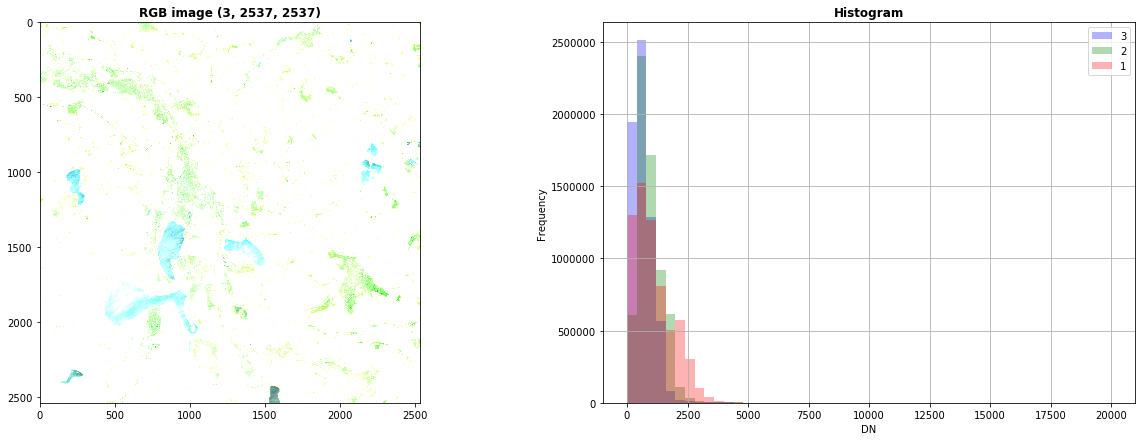

In [5]:
fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(21,7))
show(rgb_bands, ax=axrgb, title='RGB image {}'.format(rgb_bands.shape))
show_hist(rgb_bands, ax=axhist, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled')

**That didn't work as expected. Matplotlib doesn't support 16-bit images so we have to normalize all bands to 8-bit.**

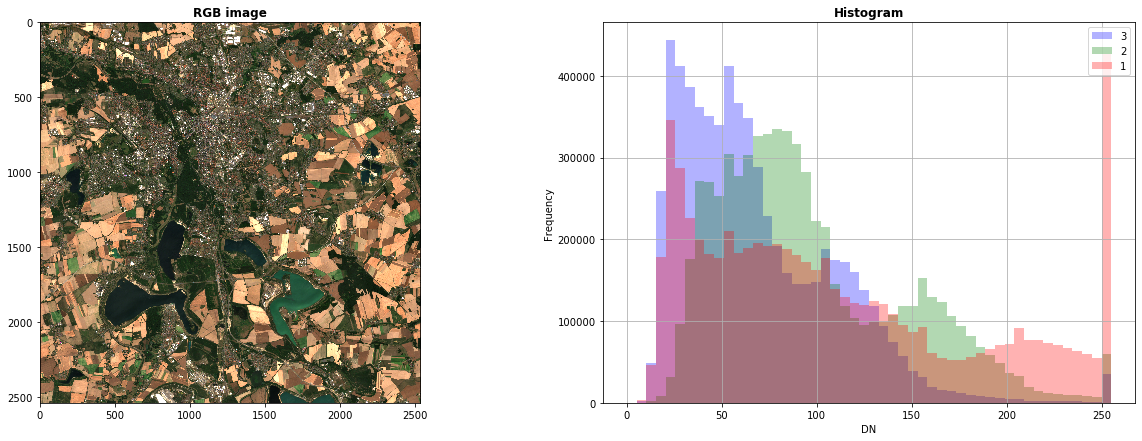

In [6]:
rgb_bands_normalized = cv2.normalize(rgb_bands, dst=None, alpha=0, beta=2048, norm_type=cv2.NORM_MINMAX, dtype=8)

fig, (axrgb, axhist) = plt.subplots(1, 2, figsize=(21,7))
show(rgb_bands_normalized, ax=axrgb, title='RGB image')
show_hist(rgb_bands_normalized, ax=axhist, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled')

## Calculating NDVI

The normalized difference vegetation index (NDVI) is an indicator to determine whether the image contains live green vegetation or not. The index is on a range from -1.0 to +1.0 where negative values correspond to water, values around 0 to barren areas or rock, sand or snow and high values approaching 1 indicate temperate and tropical rainforests.
$$NDVI = \frac{NIR - Red}{NIR + Red}$$

In [7]:
nir = all_bands[0]
red = all_bands[1]

np.seterr(divide='ignore', invalid='ignore') #sometimes the denominator is 0

ndvi = (nir.astype(float) - red) / (nir + red)

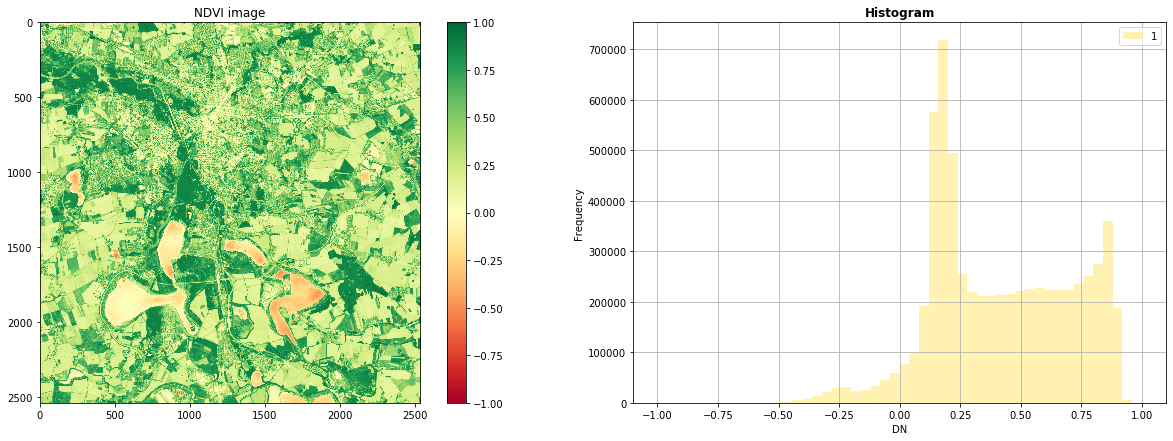

In [8]:
fig, (axndvi, axhist) = plt.subplots(1, 2, figsize=(21,7))
aximg = axndvi.imshow(ndvi, cmap='RdYlGn')
axndvi.set_title('NDVI image')
fig.colorbar(aximg, ax=axndvi)

show_hist(ndvi, bins=50, lw=0.0, stacked=False, alpha=0.3, histtype='stepfilled')

## False Color and NDWI
False color is a combination of bands 8 (NIR), 4 (Red) and 3 (Green). The normalized difference water index (NDWI) is used to monitor changes related to water content in water bodies is calculated as follows:

$$NDWI = \frac{Green - NIR}{Green + NIR}$$

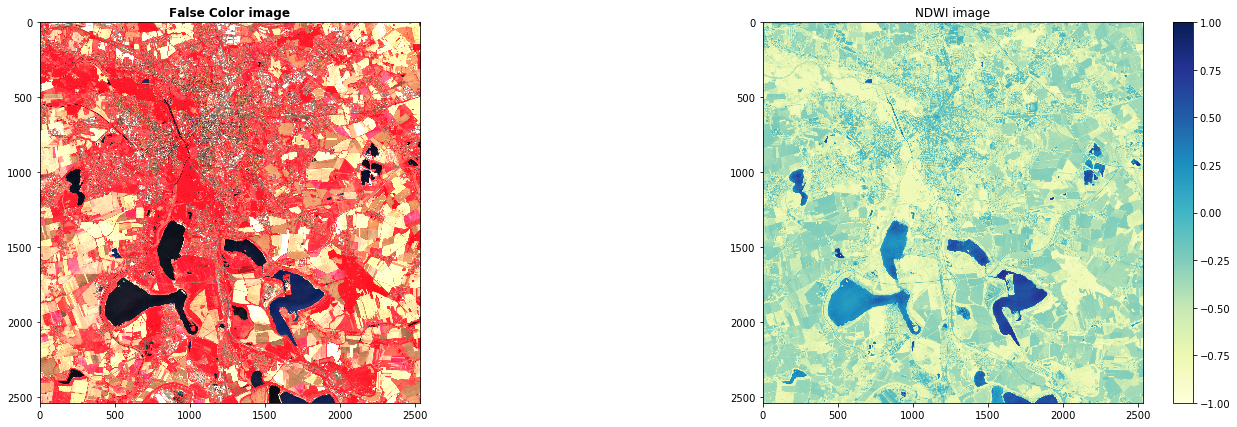

In [9]:
false_color = cv2.normalize(all_bands[:3], dst=None, alpha=0, beta=2048, norm_type=cv2.NORM_MINMAX, dtype=8)
green = all_bands[2]

ndwi = (green.astype(float) - nir) / (green + nir)

fig, (axfc, axndwi) = plt.subplots(1, 2, figsize=(24,7))

aximg = axndwi.imshow(ndwi, cmap="YlGnBu")
axndwi.set_title('NDWI image')
plt.colorbar(aximg, ax=axndwi)

show(false_color, ax=axfc, title='False Color image')
plt.show()

## Save RGB images to disk as GeoTIFF

In [10]:
def save_rgb(out_path, rgb_bands):
    with rasterio.open(jp2_dir/jp2_bands[0]) as reference:   
        with rasterio.open(out_path,
                           'w',
                           driver='Gtiff',
                           width=reference.width,
                           height=reference.height,
                           count=3,
                           crs=reference.crs,
                           transform=reference.transform,
                           dtype=rgb_bands.dtype,
                           nodata=0) as f:
            f.write(rgb_bands[0], 1)
            f.write(rgb_bands[1], 2)
            f.write(rgb_bands[2], 3)
        
out_dir = Path('out')
save_rgb(out_dir/'T32UQB_20190726T102031_RGB_16bit.tif', rgb_bands)
save_rgb(out_dir/'T32UQB_20190726T102031_RGB_8bit.tif', rgb_bands_normalized)